Image segmentation using MLP (on the EPFL dataset)

In [1]:
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
import numpy as np

import os

In [28]:
!git clone https://github.com/Shankar0x/Datasets.git imgs

fatal: destination path 'imgs' already exists and is not an empty directory.


In [29]:
image_files_trainx = [os.path.join('imgs/Skin_Lesion_Dataset/trainx', f) for f in os.listdir('imgs/Skin_Lesion_Dataset/trainx')]
image_files_trainy = [os.path.join('imgs/Skin_Lesion_Dataset/trainy', f) for f in os.listdir('imgs/Skin_Lesion_Dataset/trainy')]

image_files_testx = [os.path.join('imgs/Skin_Lesion_Dataset/testx', f) for f in os.listdir('imgs/Skin_Lesion_Dataset/testx')]
image_files_testy = [os.path.join('imgs/Skin_Lesion_Dataset/testy', f) for f in os.listdir('imgs/Skin_Lesion_Dataset/testy')]

trainx = []
trainy = []

testx = []
testy = []

# Image is being resized to a small image to make training faster.

IMAGE_DIM = 32

for path in image_files_trainx:
  img = tf.image.resize(cv2.imread(path), (IMAGE_DIM, IMAGE_DIM)) / 255.0
  trainx.append(img)

for path in image_files_trainy:
  img = tf.image.resize(cv2.imread(path), (IMAGE_DIM, IMAGE_DIM)) / 255.0
  trainy.append(img)

for path in image_files_testx:
  img = tf.image.resize(cv2.imread(path), (IMAGE_DIM, IMAGE_DIM)) / 255.0
  testx.append(img)

for path in image_files_testy:
  img = tf.image.resize(cv2.imread(path), (IMAGE_DIM, IMAGE_DIM)) / 255.0
  testy.append(img)

image_shape_input = trainx[0].shape
image_shape_output = trainy[0].shape

In [30]:
print('image shape input : ', image_shape_input)
print('image shape output : ', image_shape_output)

image shape input :  (32, 32, 3)
image shape output :  (32, 32, 3)


trainx


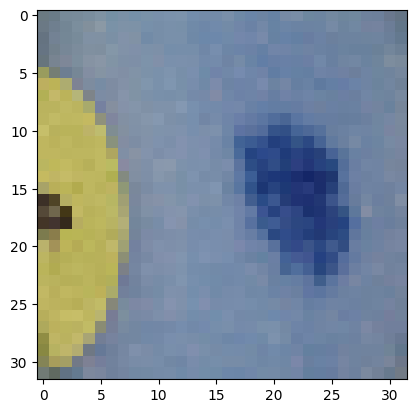

trainy


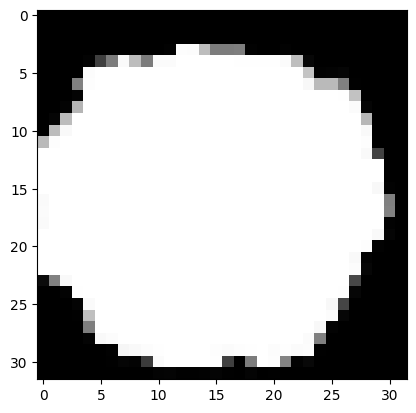

testx


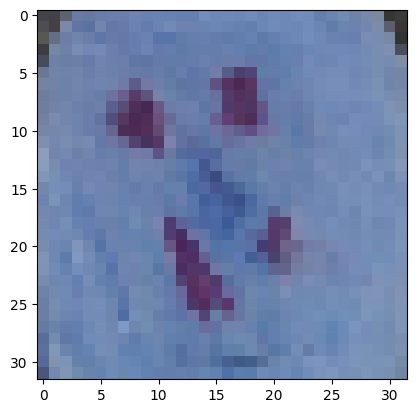

testy


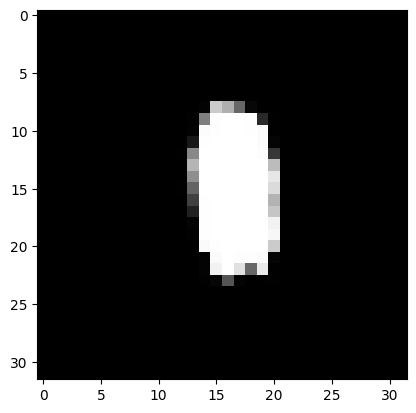

In [67]:
# Print image from each of these foldes
print('trainx')
plt.imshow(trainx[0])
plt.show()

print('trainy')
plt.imshow(trainy[0])
plt.show()

print('testx')
plt.imshow(testx[0])
plt.show()

print('testy')
plt.imshow(testy[0])
plt.show()

Training and testing the mode.

Goal is to train the model on individual pixels (1x1x3) using MLP.

In [68]:
# Input : 1x1x3
# Output : 1x1x3
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1, 1, 3)),
    tf.keras.layers.Conv2D(64, (1, 1), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(3, (1, 1), activation='sigmoid', padding='same')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1, 1, 64)          256       
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 1, 3)           195       
                                                                 
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________


In [69]:
# Reshape entire trainx and trainy into array where each elem is 1x1x3
trainx_flat = np.array(trainx).reshape(-1, 1, 1, 3)
print('overall trainx shape : ', trainx_flat.shape)
print('shape of each image : ', trainx_flat[0].shape)

trainy_flat = np.array(trainy).reshape(-1, 1, 1, 3)

overall trainx shape :  (2048000, 1, 1, 3)
shape of each image :  (1, 1, 3)


In [70]:
model.fit(trainx_flat, trainy_flat)

64000/64000 [==============================] - 143s 2ms/step - loss: 0.4645 - accuracy: 0.3260


In [71]:
testx_flat = np.array(testx).reshape(-1, 1, 1, 3)
testy_flat = np.array(testy).reshape(-1, 1, 1, 3)

loss, accuracy = model.evaluate(testx_flat, testy_flat)

print("Model Accuracy: {}".format(accuracy * 100))


19200/19200 [==============================] - 45s 2ms/step - loss: 0.5295 - accuracy: 0.2808
Model Accuracy: 28.08268368244171


Visualization

In [72]:
viz_test_image = testx_flat[:32 * 32]
predicted_output_image = model.predict(viz_test_image)

32/32 [==============================] - 0s 1ms/step


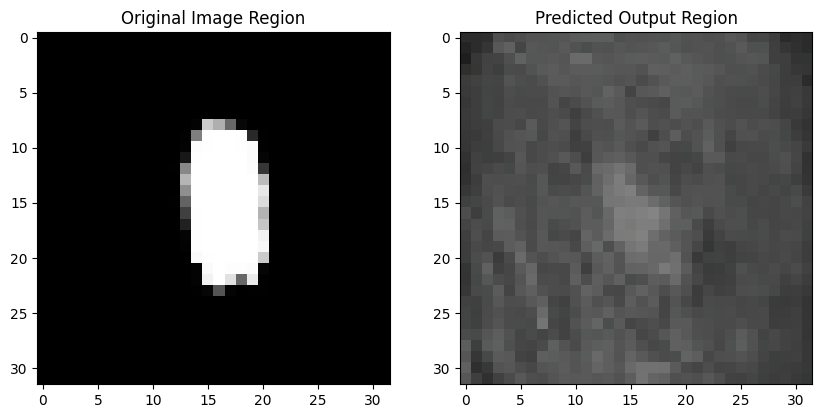

In [73]:
predicted_output_image = predicted_output_image.reshape(32, 32, 3)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.array(testy_flat[:32*32]).reshape(32, 32, 3))
plt.title('Original Image Region')

# Predicted image
plt.subplot(1, 2, 2)
plt.imshow(predicted_output_image)
plt.title('Predicted Output Region')

plt.show()

32/32 [==============================] - 0s 2ms/step


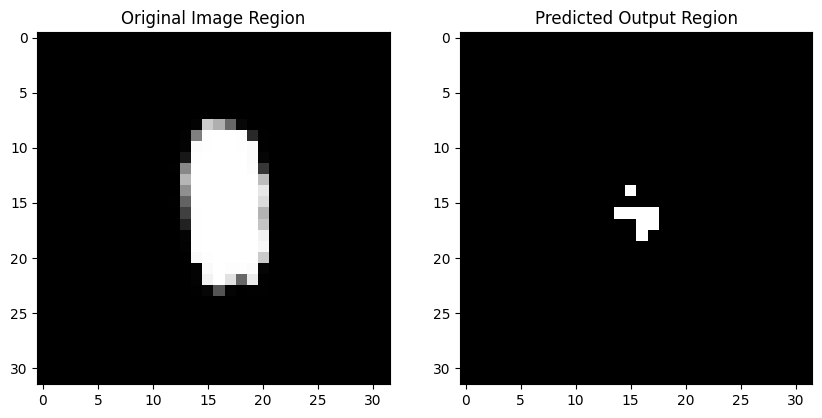

tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(32, 32), dtype=int32)


In [79]:
viz_test_image = testx_flat[:32 * 32]
predicted_output_image = model.predict(viz_test_image)

predicted_output_image = predicted_output_image.reshape(32, 32, 3)

condition = tf.reduce_all(predicted_output_image > 0.49, axis=-1)
predicted_output_image = tf.where(condition, 255, 0)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.array(testy_flat[:32*32]).reshape(32, 32, 3))
plt.title('Original Image Region')

# Predicted image
plt.subplot(1, 2, 2)
plt.imshow(predicted_output_image, cmap='gray')
plt.title('Predicted Output Region')

plt.show()

print(predicted_output_image)

Changing model to a MLP based one

In [80]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1, 1, 3)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1, 1, 256)         1024      
                                                                 
 dense_5 (Dense)             (None, 1, 1, 128)         32896     
                                                                 
 dense_6 (Dense)             (None, 1, 1, 64)          8256      
                                                                 
 dense_7 (Dense)             (None, 1, 1, 1)           65        
                                                                 
Total params: 42,241
Trainable params: 42,241
Non-trainable params: 0
_________________________________________________________________


In [81]:
# Modification of trainy to make it 1x1x1

modified_trainy = []
for img in trainy_flat:
  modified_trainy.append(img[0][0][0])

print(trainx_flat.shape, trainy_flat.shape)

modified_trainy = np.array(modified_trainy).reshape(-1, 1, 1, 1)

print(trainx_flat.shape, modified_trainy.shape)

model.fit(trainx_flat, modified_trainy)

(2048000, 1, 1, 3) (2048000, 1, 1, 3)
(2048000, 1, 1, 3) (2048000, 1, 1, 1)
64000/64000 [==============================] - 215s 3ms/step - loss: 0.4628 - accuracy: 0.7657


32/32 [==============================] - 0s 4ms/step
32


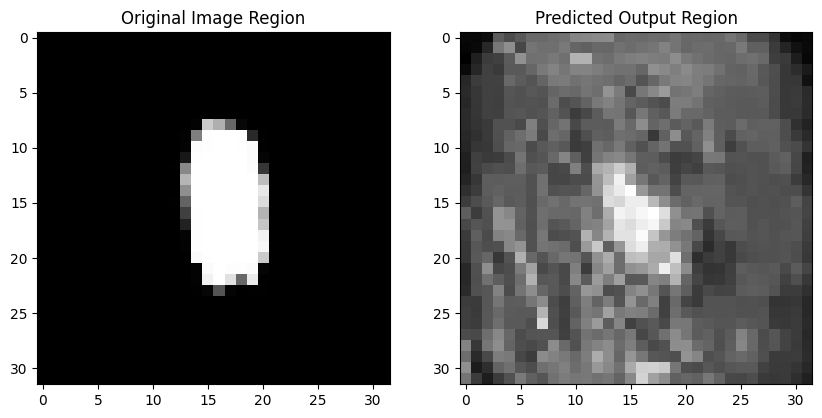

In [122]:
viz_test_image = testx_flat[:32 * 32]
predicted_output_image = model.predict(viz_test_image)

predicted_output_image = predicted_output_image.reshape(32, 32, 1)
print(predicted_output_image.shape[0])
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.array(testy_flat[:32*32]).reshape(32, 32, 3))
plt.title('Original Image Region')


# Predicted image
plt.subplot(1, 2, 2)
plt.imshow(predicted_output_image, cmap='gray')
plt.title('Predicted Output Region')

plt.show()

32/32 [==============================] - 0s 2ms/step
32


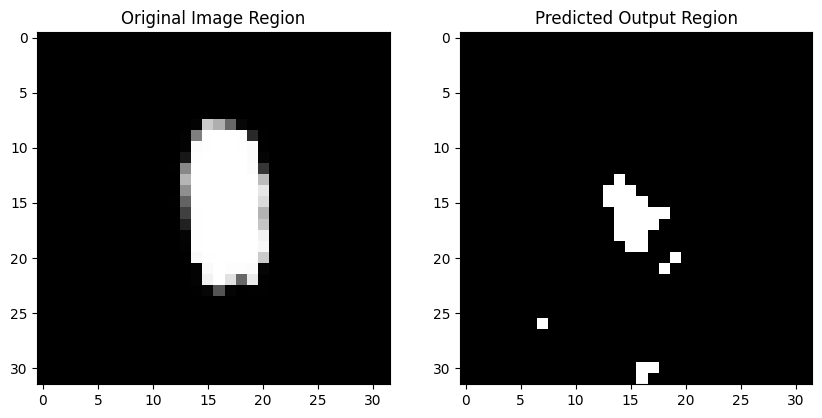

In [139]:
viz_test_image = testx_flat[:32 * 32]
predicted_output_image = model.predict(viz_test_image)

predicted_output_image = predicted_output_image.reshape(32, 32, 1)

condition = tf.reduce_all(predicted_output_image > 0.42, axis=-1)
predicted_output_image = tf.where(condition, 255, 0)

print(predicted_output_image.shape[0])

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.array(testy_flat[:32*32]).reshape(32, 32, 3))
plt.title('Original Image Region')


# Predicted image
plt.subplot(1, 2, 2)
plt.imshow(predicted_output_image, cmap='gray')
plt.title('Predicted Output Region')

plt.show()

In [84]:
testx_flat = np.array(testx).reshape(-1, 1, 1, 3)

modified_testy = []
for img in testy_flat:
  modified_testy.append(img[0][0][0])

modified_testy = np.array(modified_testy).reshape(-1, 1, 1, 1)

loss, accuracy = model.evaluate(testx_flat, modified_testy)

print("Model Accuracy: {}".format(accuracy * 100))


19200/19200 [==============================] - 38s 2ms/step - loss: 0.5291 - accuracy: 0.7184
Model Accuracy: 71.84439897537231
